# Cognitive Profiling Using Behavioral Data

## Objective
To analyze cognitive traits using mental health and digital behavior indicators
and cluster users into cognitive profiles using unsupervised learning.

In [2]:
# Imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import joblib

In [3]:
# Load Datasets 

mental_df = pd.read_csv("../data/raw/mental_health_tech.csv")
digital_df = pd.read_csv("../data/raw/digital_behavior.csv")

print("Mental Health Dataset:", mental_df.shape)
print("Digital Behavior Dataset:", digital_df.shape)

mental_df.head()

Mental Health Dataset: (1259, 27)
Digital Behavior Dataset: (500, 9)


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [4]:
# Normalize Column Names

mental_df.columns = (
    mental_df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)

digital_df.columns = (
    digital_df.columns
    .str.strip()
    .str.lower()
    .str.replace(" ", "_")
)

mental_df.columns, digital_df.columns


(Index(['timestamp', 'age', 'gender', 'country', 'state', 'self_employed',
        'family_history', 'treatment', 'work_interfere', 'no_employees',
        'remote_work', 'tech_company', 'benefits', 'care_options',
        'wellness_program', 'seek_help', 'anonymity', 'leave',
        'mental_health_consequence', 'phys_health_consequence', 'coworkers',
        'supervisor', 'mental_health_interview', 'phys_health_interview',
        'mental_vs_physical', 'obs_consequence', 'comments'],
       dtype='object'),
 Index(['daily_screen_time_min', 'num_app_switches', 'sleep_hours',
        'notification_count', 'social_media_time_min', 'focus_score',
        'mood_score', 'anxiety_level', 'digital_wellbeing_score'],
       dtype='object'))

## Select Cognitive Features

In [5]:
# Mental Health Features

mental_features = [
    "work_interfere",
    "mental_health_consequence",
    "treatment",
    "benefits",
    "care_options"
]

mental_selected = mental_df[mental_features]
mental_selected.head()


,work_interfere,mental_health_consequence,treatment,benefits,care_options
0,Often,No,Yes,Yes,Not sure
1,Rarely,Maybe,No,Don't know,No
2,Rarely,No,No,No,No
3,Often,Yes,Yes,No,Yes
4,Never,No,No,Yes,No


In [6]:
# Digital Behavior Features

digital_features = [
    "daily_screen_time_min",
    "sleep_hours",
    "focus_score",
    "mood_score",
    "anxiety_level",
    "digital_wellbeing_score"
]

digital_selected = digital_df[digital_features]
digital_selected.head()

,daily_screen_time_min,sleep_hours,focus_score,mood_score,anxiety_level,digital_wellbeing_score
0,389.8,5.9,6.8,8.9,10.0,44.8
1,351.7,7.2,5.5,9.4,10.0,43.6
2,398.9,8.0,6.7,9.4,9.4,52.6
3,451.4,6.5,6.0,9.4,5.1,58.4
4,346.0,6.9,8.2,9.4,8.0,59.7


# Combine Datasets

In [7]:
min_len = min(len(mental_selected), len(digital_selected))

combined_df = pd.concat(
    [
        mental_selected.sample(min_len, random_state=42).reset_index(drop=True),
        digital_selected.sample(min_len, random_state=42).reset_index(drop=True)
    ],
    axis=1
)

combined_df.head()

,work_interfere,mental_health_consequence,treatment,benefits,care_options,daily_screen_time_min,sleep_hours,focus_score,mood_score,anxiety_level,digital_wellbeing_score
0,NaN,No,No,Yes,Yes,452.0,7.1,7.0,10.0,10.0,49.3
1,Never,Maybe,No,Yes,Yes,453.9,8.7,7.3,10.0,6.9,64.5
2,Often,Yes,No,No,Not sure,489.2,6.3,6.4,9.1,10.0,44.8
3,NaN,Maybe,No,Don't know,No,317.1,8.1,7.9,9.3,7.5,63.6
4,Sometimes,Maybe,Yes,Don't know,Not sure,350.3,6.4,6.0,9.4,6.4,53.7


# Handle Missing Values

In [8]:
combined_df.isnull().sum()

work_interfere               98
mental_health_consequence     0
treatment                     0
benefits                      0
care_options                  0
daily_screen_time_min         0
sleep_hours                   0
focus_score                   0
mood_score                    0
anxiety_level                 0
digital_wellbeing_score       0
dtype: int64

In [9]:
combined_df = combined_df.fillna({
    col: combined_df[col].mode()[0] if combined_df[col].dtype == "object"
    else combined_df[col].median()
    for col in combined_df.columns
})

combined_df.isnull().sum()

work_interfere               0
mental_health_consequence    0
treatment                    0
benefits                     0
care_options                 0
daily_screen_time_min        0
sleep_hours                  0
focus_score                  0
mood_score                   0
anxiety_level                0
digital_wellbeing_score      0
dtype: int64

# Encode Categorical Features

In [10]:
encoded_df = combined_df.copy()

for col in encoded_df.columns:
    if encoded_df[col].dtype == "object":
        encoded_df[col] = LabelEncoder().fit_transform(encoded_df[col])

encoded_df.head()

,work_interfere,mental_health_consequence,treatment,benefits,care_options,daily_screen_time_min,sleep_hours,focus_score,mood_score,anxiety_level,digital_wellbeing_score
0,3,1,0,2,2,452.0,7.1,7.0,10.0,10.0,49.3
1,0,0,0,2,2,453.9,8.7,7.3,10.0,6.9,64.5
2,1,2,0,1,1,489.2,6.3,6.4,9.1,10.0,44.8
3,3,0,0,0,0,317.1,8.1,7.9,9.3,7.5,63.6
4,3,0,1,0,1,350.3,6.4,6.0,9.4,6.4,53.7


# Feature Scaling

In [11]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(encoded_df)

# Train K-Means Cognitive Model

In [12]:
kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=10
)

clusters = kmeans.fit_predict(scaled_features)
encoded_df["cognitive_cluster"] = clusters
encoded_df.head()

,work_interfere,mental_health_consequence,treatment,benefits,care_options,daily_screen_time_min,sleep_hours,focus_score,mood_score,anxiety_level,digital_wellbeing_score,cognitive_cluster
0,3,1,0,2,2,452.0,7.1,7.0,10.0,10.0,49.3,1
1,0,0,0,2,2,453.9,8.7,7.3,10.0,6.9,64.5,0
2,1,2,0,1,1,489.2,6.3,6.4,9.1,10.0,44.8,2
3,3,0,0,0,0,317.1,8.1,7.9,9.3,7.5,63.6,0
4,3,0,1,0,1,350.3,6.4,6.0,9.4,6.4,53.7,2


# Visualize Cognitive Clusters

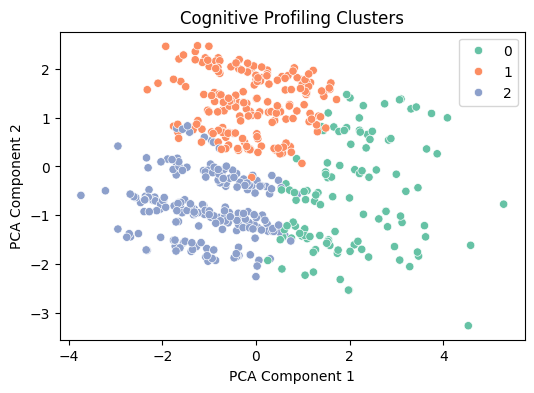

In [13]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

plt.figure(figsize=(6, 4))
sns.scatterplot(
    x=pca_features[:, 0],
    y=pca_features[:, 1],
    hue=clusters,
    palette="Set2"
)
plt.title("Cognitive Profiling Clusters")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

## Cognitive Cluster Interpretation

- Cluster 0: Balanced cognitive state
- Cluster 1: High cognitive load and anxiety
- Cluster 2: Low focus and digital fatigue

In [14]:
# Save Model

joblib.dump(kmeans, "../models/cognitive_kmeans.pkl")
joblib.dump(scaler, "../models/cognitive_scaler.pkl")

['../models/cognitive_scaler.pkl']